In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

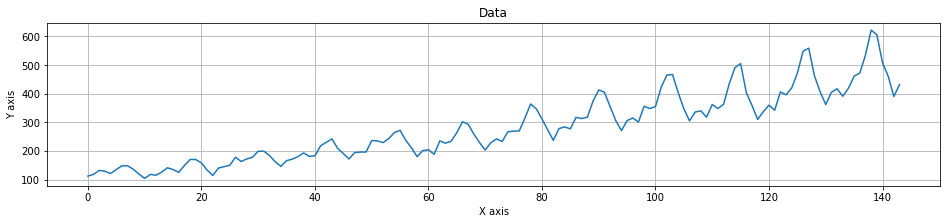

In [2]:
fileName = 'datosT1P2.txt'
data = np.loadtxt(fileName)

fig = plt.figure(0,(16,3))
plt.plot(data[:,0],data[:,1])
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.grid()
plt.show(fig)

Total data: 144
Train data: 108
Test data : 36


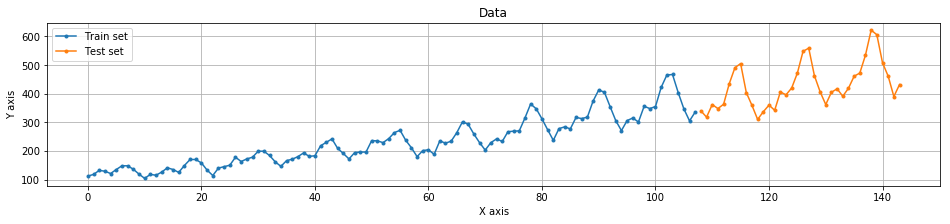

0.0 107.0
112.0 336.0


In [3]:
nData = data.shape[0]
nTrain = int(np.ceil(0.75*nData))

print('Total data: %i\nTrain data: %i\nTest data : %i' %(nData, nTrain, nData-nTrain))

train_set = data[0:nTrain,:]
test_set  = data[nTrain:,:]

fig = plt.figure(0,(16,3))
plt.plot(train_set[:,0],train_set[:,1],'.-')
plt.plot(test_set[:,0],test_set[:,1],'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Test set'))
plt.grid()
plt.show(fig)

print(train_set[0,0],train_set[-1,0])
print(train_set[0,1],train_set[-1,1])

# Model

This model have the following structure:

$$
y = f_{\theta} + \eta
$$

where, $\eta\sim N(0,\sigma_{\eta}^2)$ and $\theta$ are the parameters for $f(\cdot)$. Then, the probability associated to $(x,y)$ is given by:

$$
p(y|f(\cdot), x) = \frac{1}{\sqrt{2\pi\sigma_{\eta}^2}}\exp{\left(-\frac{(y-f(x))^2}{2\sigma_{\eta}^2}\right)}
$$

In this case, the model for $f(\cdot)$ is a polynomial. Then, $\theta = [\theta_0, \theta_1, ..., \theta_n]$ where:

$$
f(x) = \theta_0 + \theta_1x + ...+ \theta_n x^n
$$

In [143]:
import theano.tensor as tt

grade = 3

k = np.linspace(0,grade,grade+1)
X = train_set[:,0]
print('X shape: %s' % X.shape)

Y = train_set[:,1]
print('Y shape: %s' % Y.shape)


basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    theta = pm.Normal('theta', mu=0, sd=100, shape = 4)
    # theta3 = pm.Normal('theta3', mu=0, sd=100)
    # sigma = pm.HalfNormal('sigma', sd=10)
    sigma = pm.HalfNormal('sigma_y', sd=200)

    # Expected value of outcome
    mu_obs = theta[3]+theta[2]*X#+theta[1]*np.power(X,2)#+theta[0]*np.power(X,3)
    # mu_obs = np.sum(np.dot(theta,X_aux),axis = 1)
    print('mu_obs shape: %s'% mu_obs.shape)
        
    # Model
    Y_obs = pm.Normal('Y_obs', mu=mu_obs, sd=sigma, observed=Y)
    
    ## sample using MEtropolis
    # step = pm.Metropolis()
    # trace = pm.sample(10000, step)

map_estimate = pm.find_MAP(model=basic_model)

print(map_estimate)

X shape: 108
Y shape: 108
mu_obs shape: Shape.0
Optimization terminated successfully.
         Current function value: 561.359158
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
{'theta': array([  0.        ,   0.        ,   2.49883659,  97.10011263]), 'sigma_y_log_': array(3.555989294959276)}


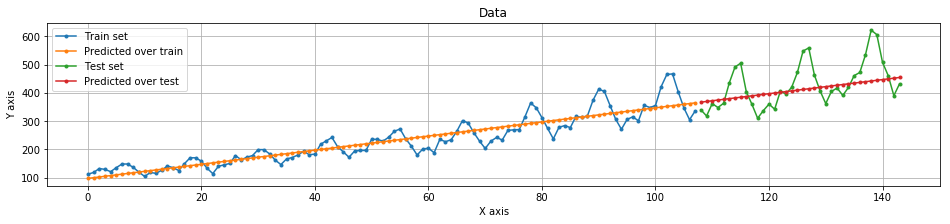

In [144]:
# theta = [float(map_estimate['theta1']),float(map_estimate['theta0'])]
theta = map_estimate['theta']
# theta = [float(map_estimate['theta3']), float(map_estimate['theta2']), float(map_estimate['theta1']),float(map_estimate['theta0'])]

X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat_pol = np.polyval(theta,X)
Y_hat_pol = np.polyval(theta,X_test)

fig = plt.figure(0,(16,3))
plt.plot(X,Y,'.-')
plt.plot(X,Y_train_hat_pol,'.-')
plt.plot(X_test,Y_test,'.-')
plt.plot(X_test,Y_hat_pol ,'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'))
plt.grid()
plt.savefig('final.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show(fig)

In [209]:
import mle
import theano.tensor as tt
import theano

# for ommit AttributeError: x has no test value
theano.config.compute_test_value = 'ignore'

def fpol(a,x):
    return a[3]+a[2]*x+a[1]*np.power(x,2)+a[0]*np.power(x,3)

X = train_set[:,0]

print('X shape: %s' % X.shape)

Y = train_set[:,1]
print('Y shape: %s' % Y.shape)

# Define model
x = mle.var('x', observed=True, vector=True)
y = mle.var('y', observed=True, vector=True)

theta1 = mle.var('theta1')
theta2 = mle.var('theta2')
theta3 = mle.var('theta3')
theta4 = mle.var('theta4')
sigma = mle.var('sigma')



model = mle.Normal(y, theta[3]+theta[2]*X+theta[1]*np.power(X,2)+theta[0]*np.power(X,3) + theta1*tt.sin(theta2*x + theta3)*tt.exp(theta4*x), sigma)


# Fit model to data
result = model.fit({'x': X, 'y': Y}, {'theta1': 60, 'theta2':1290, 'theta3': 80, 'theta4': 0.01, 'sigma': 1})
print(result)

X shape: 108
Y shape: 108
Optimization terminated successfully.
         Current function value: 481.595461
         Iterations: 270
         Function evaluations: 359
         Gradient evaluations: 355
 fit_time: 0.11685400000001778
      fun: 481.595460999823
 hess_inv: array([[  2.04054345e+00,   1.20182463e-03,  -1.57928970e-05,
          2.24106337e-03,   1.25880943e-05],
       [  1.20182463e-03,   1.02419890e+01,   1.30071999e-05,
         -6.94864589e-03,   9.81818874e-03],
       [ -1.57928970e-05,   1.30071999e-05,   9.11444174e-06,
         -7.47292965e-04,  -1.21754085e-07],
       [  2.24106337e-03,  -6.94864589e-03,  -7.47292965e-04,
          6.63843103e-02,   3.19988254e-06],
       [  1.25880943e-05,   9.81818874e-03,  -1.21754085e-07,
          3.19988254e-06,   1.01777943e-05]])
      jac: array([  2.94953117e-10,  -1.12968903e-09,   7.28753695e-07,
         1.07332397e-08,   1.21437662e-06])
  message: 'Optimization terminated successfully.'
     nfev: 359
      nit

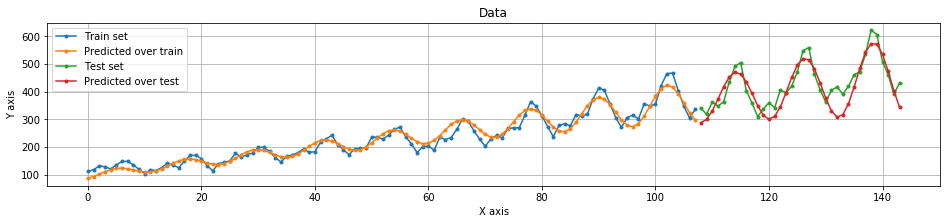

In [210]:
theta_sin = [float(result.x['theta1']), float(result.x['theta2']), float(result.x['theta3']),float(result.x['theta4'])]

X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat_polsin = np.polyval(theta,X)+ float(result.x['theta1'])*np.sin(float(result.x['theta2'])*X + float(result.x['theta3']))*np.exp(float(result.x['theta4'])*X)
Y_hat_polsin = np.polyval(theta,X_test) + float(result.x['theta1'])*np.sin(float(result.x['theta2'])*X_test + float(result.x['theta3']))*np.exp(float(result.x['theta4'])*X_test)

fig = plt.figure(0,(16,3))
plt.plot(X,Y,'.-')
plt.plot(X,Y_train_hat_polsin,'.-')
plt.plot(X_test,Y_test,'.-')
plt.plot(X_test,Y_hat_polsin ,'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'))
plt.grid()
plt.savefig('final.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show(fig)

In [360]:
def f_pol_sin(x,a,b):
    return a[3]+a[2]*x+a[1]*np.power(x,2)+a[0]*np.power(x,3)+ b[0]*np.sin(b[1]*x+b[2])*np.exp(b[3]*x)

X = train_set[:,0]

print('X shape: %s' % X.shape)

Y = train_set[:,1]
print('Y shape: %s' % Y.shape)

# Define model
x = mle.var('x', observed=True, vector=True)
y = mle.var('y', observed=True, vector=True)

theta1 = mle.var('theta1')
theta2 = mle.var('theta2')
theta3 = mle.var('theta3')
theta4 = mle.var('theta4')
sigma = mle.var('sigma')


model = mle.Normal(y, f_pol_sin(x,theta,theta_sin) + theta1*tt.sin(theta2*x + theta3)*tt.exp(theta4*x), sigma)


# Fit model to data
result = model.fit({'x': X, 'y': Y}, {'theta1': 100, 'theta2': 120, 'theta3': 200, 'theta4': 0.1, 'sigma': 100})
print(result)

X shape: 108
Y shape: 108
Optimization terminated successfully.
         Current function value: 448.429036
         Iterations: 79
         Function evaluations: 133
         Gradient evaluations: 121
 fit_time: 0.041879999999991924
      fun: 448.4290364743282
 hess_inv: array([[  1.06217606e+00,   1.01530529e-02,  -2.25640524e-05,
          2.13734002e-03,  -1.62914291e-05],
       [  1.01530529e-02,   9.52200881e+00,  -3.63247995e-04,
          2.57493974e-02,  -1.14460635e-02],
       [ -2.25640524e-05,  -3.63247995e-04,   1.30361850e-05,
         -9.53989028e-04,   4.98718368e-07],
       [  2.13734002e-03,   2.57493974e-02,  -9.53989028e-04,
          8.05223973e-02,  -3.48260499e-05],
       [ -1.62914291e-05,  -1.14460635e-02,   4.98718368e-07,
         -3.48260499e-05,   1.56015309e-05]])
      jac: array([ -4.59284788e-09,   3.48634361e-09,  -1.68065453e-06,
        -3.90209083e-08,   2.43218209e-06])
  message: 'Optimization terminated successfully.'
     nfev: 133
      ni

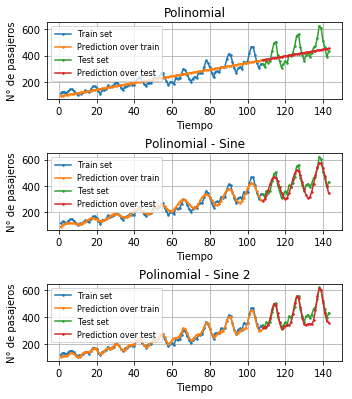

In [361]:
theta_sin_sin = [float(result.x['theta1']), float(result.x['theta2']), float(result.x['theta3']),float(result.x['theta4'])]

X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat = f_pol_sin(X,theta,theta_sin)+ float(result.x['theta1'])*np.sin(float(result.x['theta2'])*X + float(result.x['theta3']))*np.exp(float(result.x['theta4'])*X)
Y_hat = f_pol_sin(X_test,theta,theta_sin) + float(result.x['theta1'])*np.sin(float(result.x['theta2'])*X_test + float(result.x['theta3']))*np.exp(float(result.x['theta4'])*X_test)

fig, ax = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(5)

ax[0].plot(X[1:],Y[1:],'.-', ms = 3)
ax[0].plot(X[1:],Y_train_hat_pol[1:],'.-', ms = 3)
ax[0].plot(X_test,Y_test,'.-', ms = 3)
ax[0].plot(X_test,Y_hat_pol ,'.-', ms = 3)
ax[0].set_title('Polinomial')
ax[0].set_xlabel('Tiempo')
ax[0].set_ylabel('N° de pasajeros')
ax[0].legend(('Train set', 'Prediction over train', 'Test set', 'Prediction over test'), prop={'size':8})
ax[0].grid()

ax[1].plot(X[1:],Y[1:],'.-', ms = 3)
ax[1].plot(X[1:],Y_train_hat_polsin[1:],'.-', ms = 3)
ax[1].plot(X_test,Y_test,'.-', ms = 3)
ax[1].plot(X_test,Y_hat_polsin ,'.-', ms = 3)
ax[1].set_title('Polinomial - Sine')
ax[1].set_xlabel('Tiempo')
ax[1].set_ylabel('N° de pasajeros')
ax[1].legend(('Train set', 'Prediction over train', 'Test set', 'Prediction over test'), prop={'size':8})
ax[1].grid()

ax[2].plot(X[1:],Y[1:],'.-', ms = 3)
ax[2].plot(X[1:],Y_train_hat[1:],'.-', ms = 3)
ax[2].plot(X_test,Y_test,'.-', ms = 3)
ax[2].plot(X_test,Y_hat ,'.-', ms = 3)
ax[2].set_title('Polinomial - Sine 2')
ax[2].set_xlabel('Tiempo')
ax[2].set_ylabel('N° de pasajeros')
ax[2].legend(('Train set', 'Prediction over train', 'Test set', 'Prediction over test'), prop={'size':8})
ax[2].grid()

plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig('final.eps', format = 'eps', bbox_inches = 'tight')
plt.show(fig)

In [265]:
argMSE = (Y_test-Y_hat_pol)**2
MSE = np.mean(argMSE)
print("Polinomial MSE: %s" % MSE)

argMSE = (Y_test-Y_hat_polsin)**2
MSE = np.mean(argMSE)
print("Polinomial sine MSE: %s" % MSE)

argMSE = (Y_test-Y_hat)**2
MSE = np.mean(argMSE)
print("Polinomial sine 2 MSE: %s" % MSE)

Polinomial MSE: 4975.95515951
Polinomial sine MSE: 1939.8143745
Polinomial sine 2 MSE: 1232.4672412
